# Exploratory Analysis of Domestic Flights Arriving at LaGuardia

Data source:

Bureau of Transportation Statistics, United States Department of Transportation

https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

# Read the data into a single dataframe

Manually downloaded airline [On-Time Performance data set](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for every month from January 2016 through 2017 YTD as zip files to `data/flights/`.

Concatenate all of these files into a single data frame.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline

In [3]:
def read_flight_data(path_to_data):
    list_of_dataframes = []
    
    for filename in os.listdir(path_to_data):
        df = pd.read_csv(os.path.join(path_to_data, filename), compression='infer')
        list_of_dataframes.append(df)
    
    output = pd.concat(list_of_dataframes)
    
    # Drop any columns with "Unnamed" in the header
    drop_columns = [i for i in output.columns if 'Unnamed' in i]
    output = output.drop(drop_columns, axis=1)
    
    # Filter the data to only include flights arriving at LGA
    output = output[output['DEST'] == 'LGA']
    
    # Sort output by date and scheduled departure time
    output['FL_DATE'] = pd.to_datetime(output['FL_DATE'])
    output = output.sort_values(by=['FL_DATE', 'CRS_DEP_TIME'])
    output = output.reset_index(drop=True)
    
    return output     

In [4]:
df = read_flight_data("../raw_data/flights")

In [5]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY
0,2016,1,1,1,5,2016-01-01,NK,20416,NK,N641NK,...,22,546,NaN,NaN,NaN,NaN,NaN,850,NaN,NaN
1,2016,1,1,1,5,2016-01-01,NK,20416,NK,N636NK,...,22,600,624.0,24.0,24.0,740.0,8.0,735,748.0,13.0
2,2016,1,1,1,5,2016-01-01,B6,20409,B6,N623JB,...,22,600,556.0,-4.0,0.0,806.0,5.0,825,811.0,-14.0
3,2016,1,1,1,5,2016-01-01,B6,20409,B6,N599JB,...,22,600,553.0,-7.0,0.0,819.0,5.0,841,824.0,-17.0
4,2016,1,1,1,5,2016-01-01,AA,19805,AA,N3KRAA,...,22,605,714.0,69.0,69.0,947.0,5.0,857,952.0,55.0


# Exploratory Data Analysis

### How many flights arrive at LaGuardia per day?

In [6]:
def count_flights_per_day(df):
    flights_per_day = pd.DataFrame(columns = ['FL_DATE','NUM_FLIGHTS'])
    flights_per_day['FL_DATE'] = df['FL_DATE'].value_counts().index
    flights_per_day['NUM_FLIGHTS'] = df['FL_DATE'].value_counts().values
    flights_per_day = flights_per_day.sort_values(by='FL_DATE')
    flights_per_day = flights_per_day.reset_index(drop=True)
    
    # Plot number of arrivals at LGA per day
    ax = flights_per_day.plot(kind='bar', figsize=(60,20), title='Number of LGA Arrivals per Day Since Jan 2016')
    ax.set_xticklabels(flights_per_day['FL_DATE'].dt.date) # removes timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    
    return flights_per_day

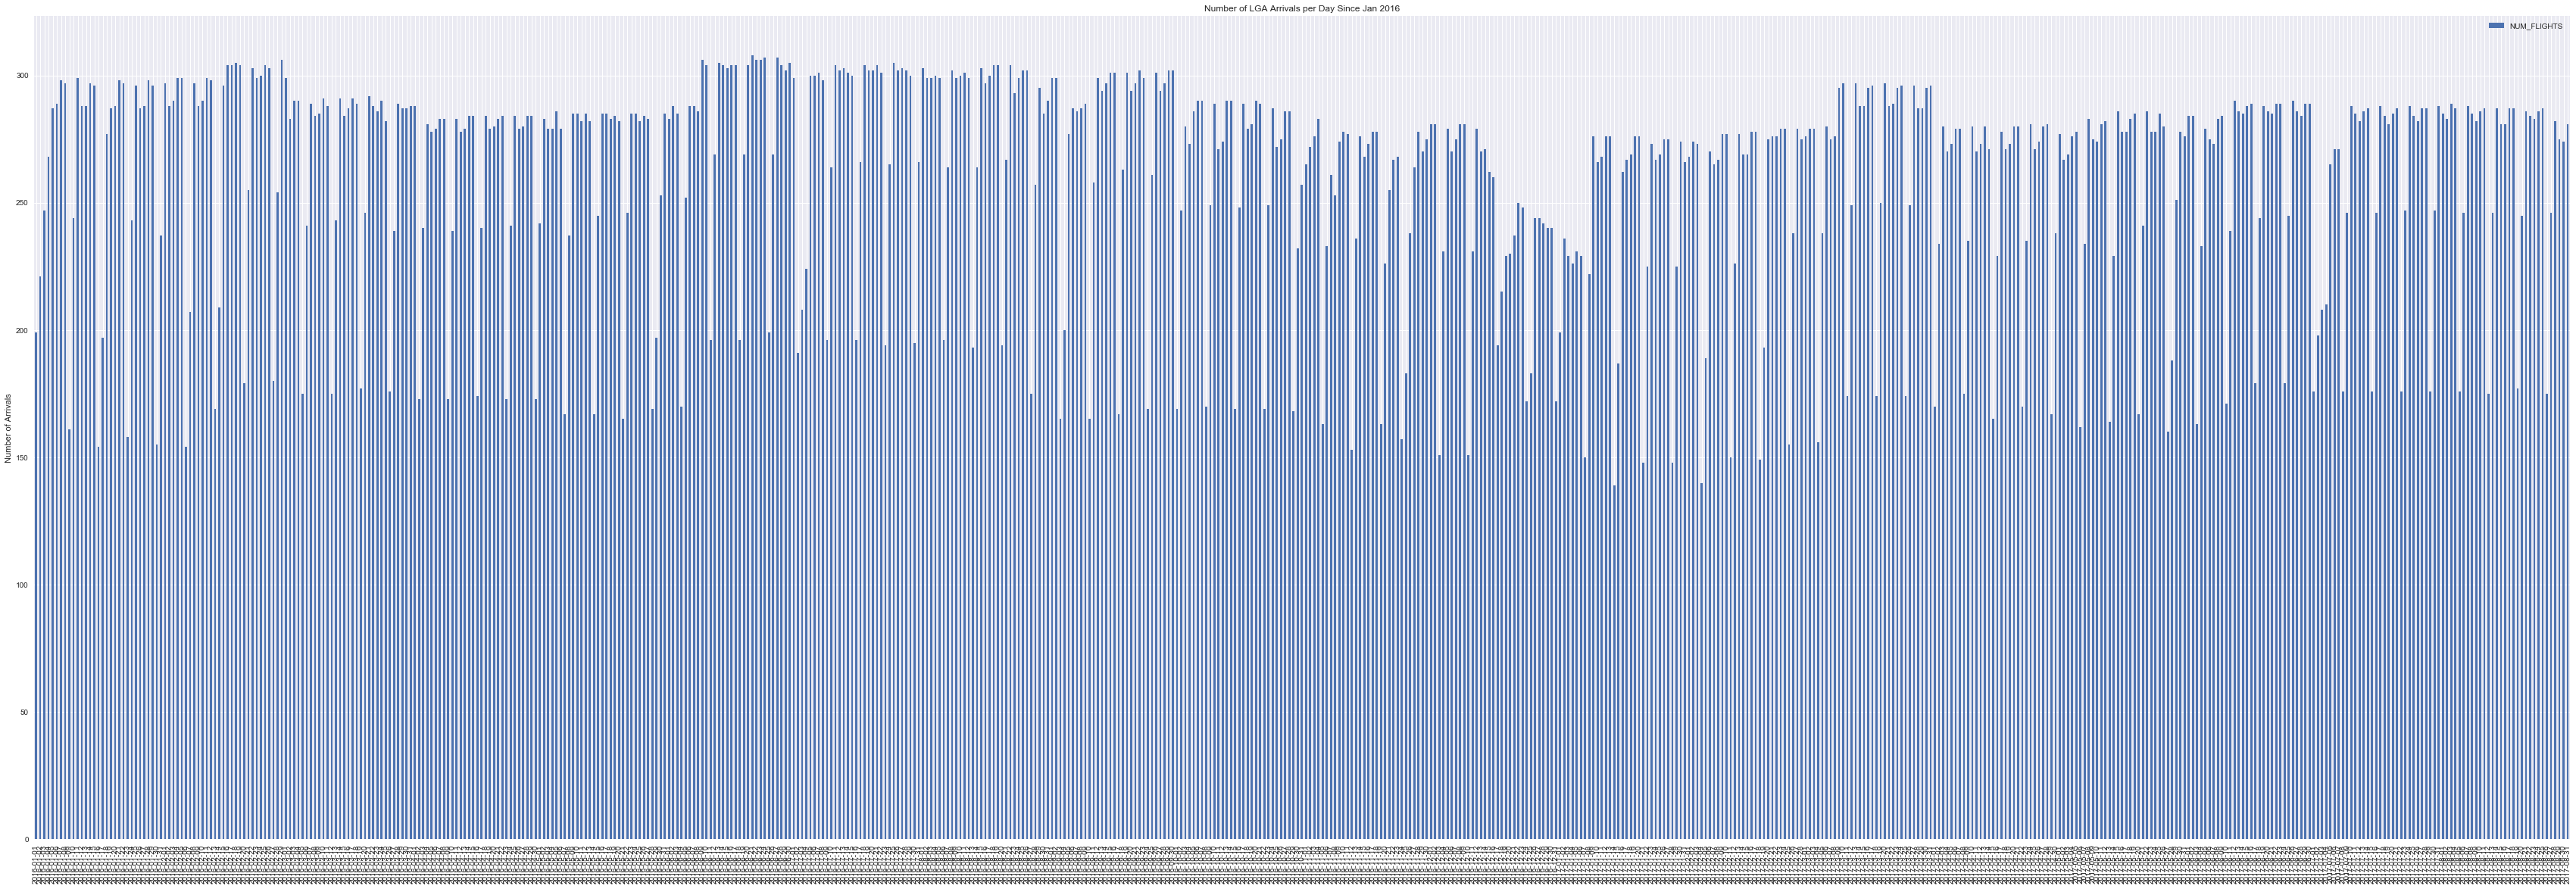

In [7]:
flights_per_day = count_flights_per_day(df)

In [8]:
flights_per_day.head()

,FL_DATE,NUM_FLIGHTS
0,2016-01-01,199
1,2016-01-02,221
2,2016-01-03,247
3,2016-01-04,268
4,2016-01-05,287


### How many flights arrive at LaGuardia per month?

In [9]:
def count_flights_per_month(flights_per_day):
    flights_per_day.index = flights_per_day['FL_DATE'] # Set index to date so we can use TimeGrouper
    flights_per_month = pd.DataFrame(flights_per_day.groupby(pd.TimeGrouper(freq='M')).sum())
    
    # Plot number of arrivals at LGA per month
    ax = flights_per_month.plot(kind='bar', title='Number of LGA Arrivals per Month Since Jan 2016', legend=False, 
                                figsize=(16,8), fontsize=14)
    ax.set_xticklabels(pd.Series(flights_per_month.index).apply(dt.date).apply(lambda x: str(x)[:7])) # removes day and timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    ax.set_xlabel("Month")
    
    return flights_per_month

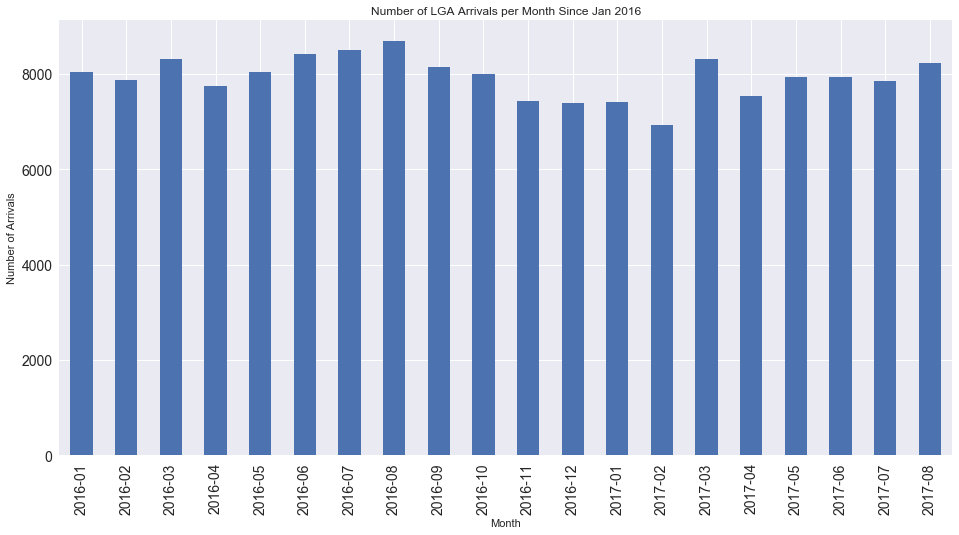

In [10]:
flights_per_month = count_flights_per_month(flights_per_day)

In [11]:
flights_per_month.head()

,NUM_FLIGHTS
FL_DATE,
2016-01-31,8035
2016-02-29,7880
2016-03-31,8302
2016-04-30,7747
2016-05-31,8036


### What is the average number of flights arriving per hour?

Actual arrival time (`ARR_TIME`) comes in a weird format: "hhmm" (local time)

Here's a function to convert "hhmm" format to a datetime time object.

In [12]:
def convert_hhmm_to_time(hhmm):
    hhmm = str(int(hhmm))
    
    if hhmm == '2400': # hour must be btw 0 and 23
        hhmm = '2359'  
    
    if len(hhmm) > 2:  # to handle conversions like '1025' => 10:25:00
        hour = hhmm[:-2]
        minute = hhmm[-2:]
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time) 
        
    if len(hhmm) <= 2: # to handle conversions like '2' => 00:02:00
        hour = "00"
        minute = hhmm.zfill(2)
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time)
        
    return str(time)

Test it out to make sure it works:

In [13]:
convert_hhmm_to_time(1025.0)

'10:25:00'

In [14]:
def calculate_avg_flights_per_hour(df):
    time_stamps = pd.Series(df['ARR_TIME'].dropna())
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    hours = time_stamps.apply(lambda x: x.split(':')[0])
    hours = pd.DataFrame(hours)
    hours.columns = ['ARR_HOUR']
    count_per_hour = hours['ARR_HOUR'].value_counts().sort_index()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_hour = count_per_hour / number_of_days
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_hour.plot(kind='bar', title='Average Number of Arriving Flights per Hour per Day at LaGuardia', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Hour")
    
    return average_per_hour

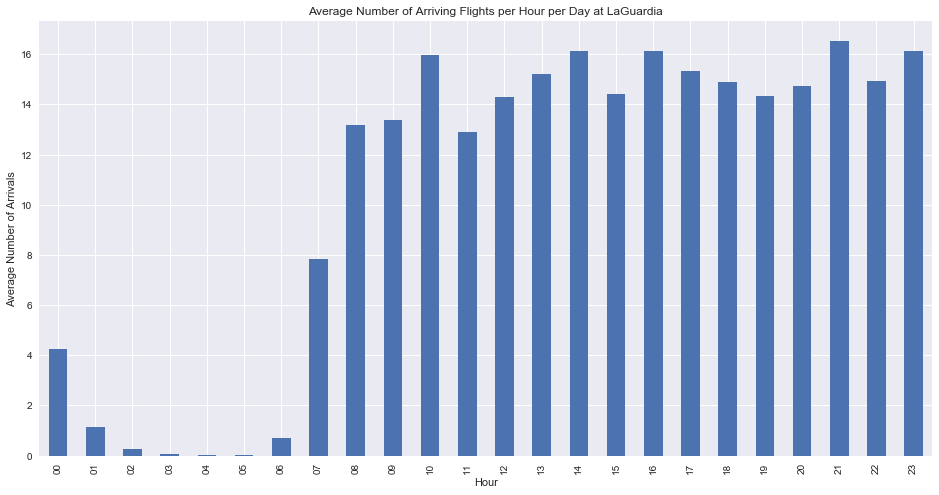

In [15]:
avg_flights_per_hour = calculate_avg_flights_per_hour(df)

In [16]:
avg_flights_per_hour

00     4.241776
01     1.128289
02     0.253289
03     0.054276
04     0.026316
05     0.027961
06     0.680921
07     7.851974
08    13.159539
09    13.363487
10    15.967105
11    12.911184
12    14.300987
13    15.213816
14    16.146382
15    14.424342
16    16.129934
17    15.337171
18    14.889803
19    14.350329
20    14.730263
21    16.511513
22    14.924342
23    16.123355
Name: ARR_HOUR, dtype: float64

### What is the average number of flights arriving by day of week?

In [17]:
days_of_week = {
    "1":"Monday",
    "2":"Tuesday",
    "3":"Wednesday",
    "4":"Thursday",
    "5":"Friday",
    "6":"Saturday",
    "7":"Sunday",
    "9":"Unknown"
}

In [18]:
def calculate_avg_flights_per_day_of_week(df, days_of_week):
    counts_by_day_of_week = df['DAY_OF_WEEK'].value_counts().sort_index()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_day_of_week = counts_by_day_of_week / number_of_days

    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_day_of_week.plot(kind='bar', title='Average Number of Arriving Flights at LaGuardia by Day of Week', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Day of Week")
    xticklabels = [days_of_week[str(i)] for i in list(average_per_day_of_week.index)]
    ax.set_xticklabels(xticklabels)

    return average_per_day_of_week

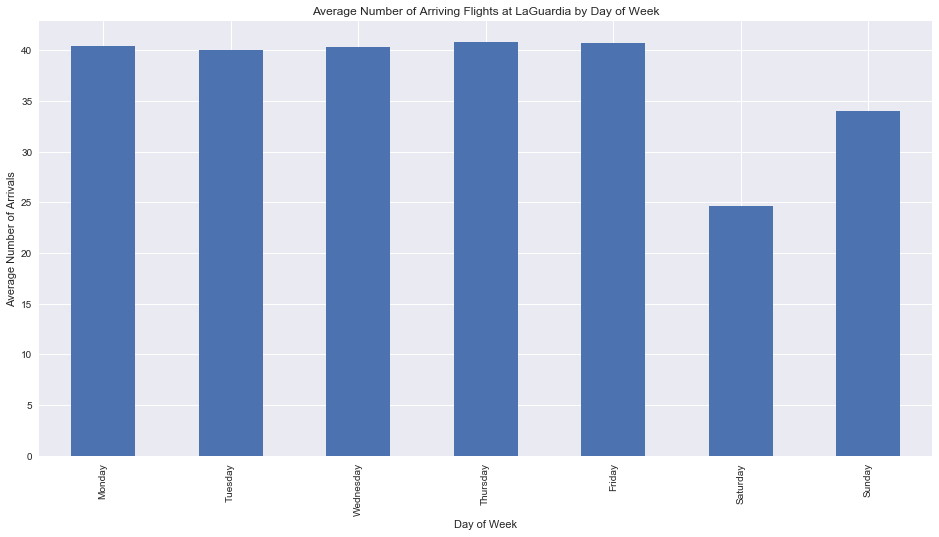

In [19]:
avg_flights_per_day = calculate_avg_flights_per_day_of_week(df, days_of_week)

### Count number of flights for every hour since 2016

In [41]:
def count_flights_per_hour(df):
    data = df.copy()
    data = data.dropna(subset=['ARR_TIME'])
    data = data.reset_index(drop=True)
    time_stamps = pd.Series(data['ARR_TIME'])
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    data['TIME_STAMP'] = time_stamps
    dates = pd.Series(data['FL_DATE'].apply(lambda x: str(x).split(" ")[0]))
    data['DATE_STRING'] = dates
    data['FL_DATETIME'] = pd.to_datetime(data['DATE_STRING'] + " " + data['TIME_STAMP'])
    
    # Make dataframe of number of flights per hour since 2016
    output = data['FL_DATETIME']
    output.index = data['FL_DATETIME']
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).count().sort_index())
    output.columns = ['NUM_FLIGHTS']
    
    return output

In [42]:
flights_per_hour = count_flights_per_hour(df)

# Save clean dataframe to csv

In [43]:
flights_per_hour

,NUM_FLIGHTS
FL_DATETIME,
2016-01-01 00:00:00,1
2016-01-01 01:00:00,1
2016-01-01 02:00:00,0
2016-01-01 03:00:00,0
2016-01-01 04:00:00,0
2016-01-01 05:00:00,0
2016-01-01 06:00:00,0
2016-01-01 07:00:00,2
2016-01-01 08:00:00,5


In [45]:
flights_per_hour.to_csv("../clean_data/flights_per_hour.csv")

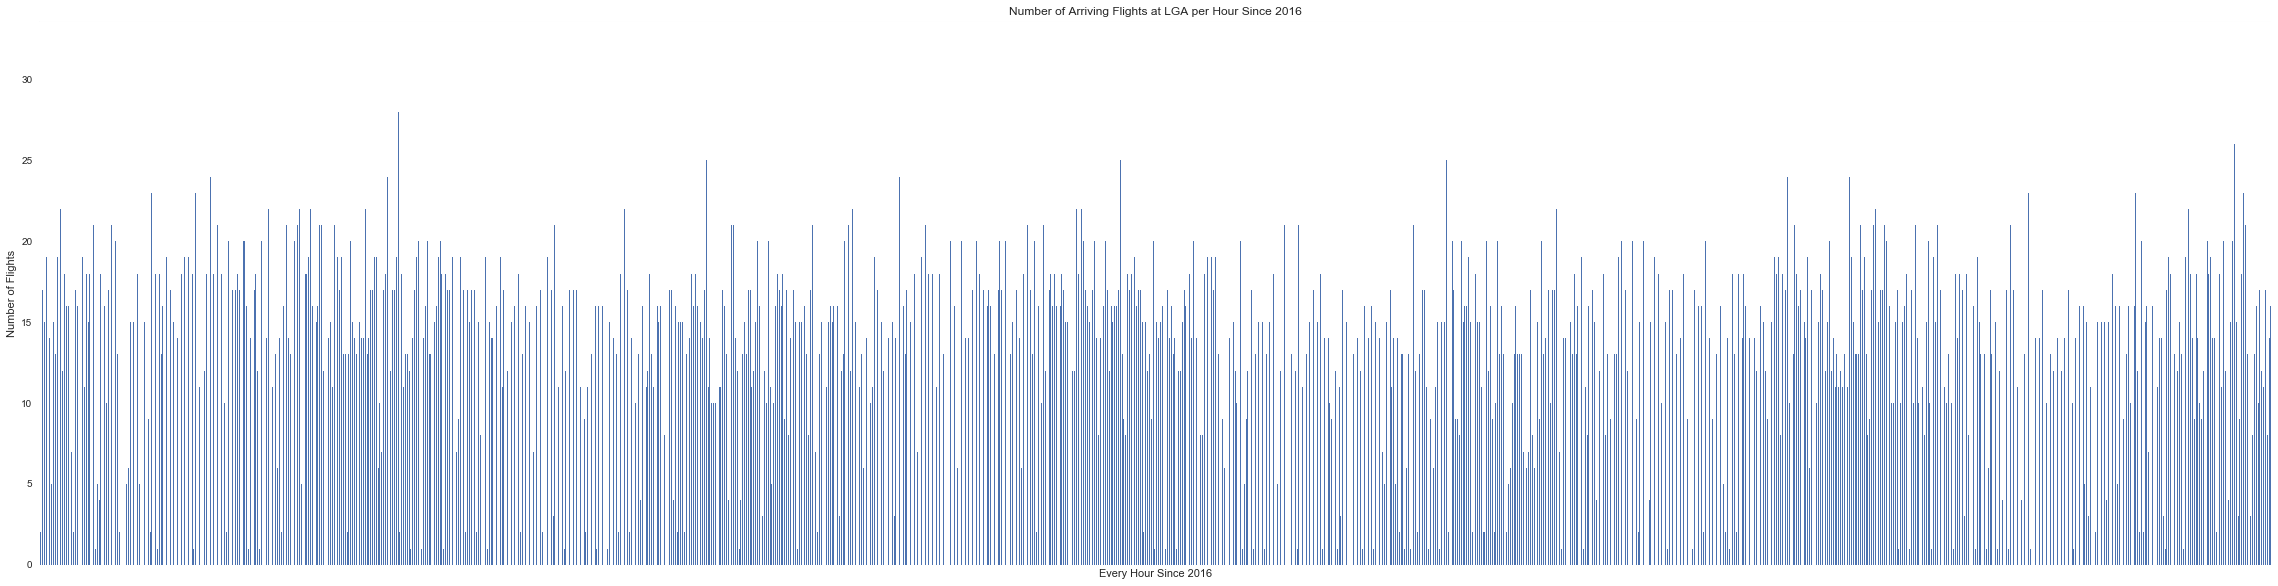

In [47]:
ax = flights_per_hour.plot(kind='bar', figsize=(40,10), title='Number of Arriving Flights at LGA per Hour Since 2016', legend=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
ax.set_xlabel("Every Hour Since 2016")
ax.set_ylabel("Number of Flights")